# Clustering schools

This is my first public kernel (yay)!  Here, I will do a very simple thing: group schools by different sets of characteristics (for example, ethnicity, framework measures, achievement performance, ...)

My hope is that by providing different groupings, PASSNYC may get a good idea of what works for one group or another. For example, let's consider 2 schools *X* and *Y*, that belong to the same group. PASSNYC may reach for school *X*, and, discover new things that are useful in *X*. Now, based on the fact that these two schools are similar, what works for *X* may also work for *Y* too.

By providing different groupings, I may stumble upon one that works best. Also, it provides a nice framework for visualizing information on a map.

## Preparing the data

In [121]:
import re

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)


df = pd.read_csv('../data/raw/2016 School Explorer.csv')

# set index
df = df.set_index('Location Code')
df.index.name = 'DBN'

# remove unused columns
columns = [
    'Adjusted Grade',   
    'New?',
    'Other Location Code in LCGMS',
    'School Name',
    'SED Code',
    'Address (Full)',
    'Rigorous Instruction Rating',
    'Collaborative Teachers Rating',
    'Supportive Environment Rating',
    'Effective School Leadership Rating',
    'Strong Family-Community Ties Rating',
    'Trust Rating',
    'Student Achievement Rating'
]
df = df.drop(columns, axis=1)

# split columns with amount of 4s
result_columns = [c for c in df.columns if re.match(r'Grade \d.+', c)]
df4s = df[result_columns]
df = df.drop(result_columns, axis=1)

# fix bad column name
df4s = df4s.rename(columns={
    'Grade 3 Math - All Students tested': 'Grade 3 Math - All Students Tested'
})

# parse values
def parse_pct(x):
    if isinstance(x, str) and x[-1] == '%':
        return float(x[:-1]) / 100
    else:
        return x
    
def parse_income(x):
    if isinstance(x, str):
        return float(x[1:].replace(',', ''))
    else:
        return np.nan
    
df = df.applymap(parse_pct)
df['Community School?'] = df['Community School?'].apply(lambda x: int(x == 'Yes'))
df['School Income Estimate'] = df['School Income Estimate'].apply(parse_income)

# fix bad attandance rate values
df.loc[df['Student Attendance Rate'] == 0.0, 'Student Attendance Rate'] = np.nan
df.loc[df['Percent of Students Chronically Absent'] == 1.0, 'Percent of Students Chronically Absent'] = np.nan

# summarize available grades
available_grades = data.apply(lambda x: x['Grade Low'] + '-' + x['Grade High'], axis=1)
se_flag = data['Grades'].str.contains('SE')
df = df.drop(['Grades', 'Grade Low', 'Grade High'], axis=1)
df['Grades'] = available_grades
df['SE Grade'] = se_flag

df.head()

,District,Latitude,Longitude,City,Zip,Community School?,Economic Need Index,School Income Estimate,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Average ELA Proficiency,Average Math Proficiency,Grades,SE Grade
DBN,,,,,,,,,,,,,,,,,,,,,,,,,,
01M015,1,40.721834,-73.978766,NEW YORK,10009,1,0.919,31141.72,0.09,0.05,0.32,0.60,0.92,0.01,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94,2.14,2.17,PK-05,False
01M019,1,40.729892,-73.984231,NEW YORK,10003,0,0.641,56462.88,0.05,0.10,0.20,0.63,0.83,0.06,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94,2.63,2.98,PK-05,False
01M020,1,40.721274,-73.986315,NEW YORK,10002,0,0.744,44342.61,0.15,0.35,0.08,0.49,0.57,0.04,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79,2.39,2.54,PK-05,False
01M034,1,40.726147,-73.975043,NEW YORK,10009,0,0.860,31454.00,0.07,0.05,0.29,0.63,0.92,0.04,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88,2.48,2.47,PK-08,False
01M063,1,40.724404,-73.986360,NEW YORK,10009,0,0.730,46435.59,0.03,0.04,0.20,0.65,0.84,0.10,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93,2.38,2.54,PK-05,False


In [43]:
### percentage of 4s for each school

import re

# melt df so that column names become a variable
melted = df4s.reset_index().melt(id_vars='DBN', value_name='Count')

# split column names (now a variable) into 'Grade', 'Test' and 'Group'
pattern = r'^Grade (?P<Grade>\d) (?P<Test>\w+) (?:- |)(?P<Group>.*)$'
split_cols = melted.variable.str.extract(pattern)

# merge new variables with DBN and Count
split = pd.concat([
    melted[['DBN', 'Count']],
    split_cols
], axis=1)[['Test', 'DBN', 'Grade', 'Group', 'Count']]

# calculate total percentage of 4s per grade in each school
def calculate_grade_pct(df):
    all_students_tested = df[df.Group == 'All Students Tested'].Count.sum()  # average for both tests
    all_students_4s = df[df.Group == '4s - All Students'].Count.sum()
    
    if all_students_tested > 0:
        return all_students_4s / all_students_tested
    else:
        return np.nan
aggregate = split.groupby(['DBN', 'Grade']).apply(calculate_grade_pct).rename('Mean 4s').reset_index()

# unstack results so we can use them with parallel_coordinates
planified = aggregate.set_index(['DBN', 'Grade'])['Mean 4s'].unstack()
planified.columns.name = None
planified.columns = ["Grade {}".format(c) for c in planified.columns]

# nicer name
percentage4s = planified.copy()
percentage4s.head()

,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,Grade 8
DBN,,,,,,
01M015,0.000000,0.066667,0.000000,NaN,NaN,NaN
01M019,0.121212,0.263158,0.171875,NaN,NaN,NaN
01M020,0.111842,0.156028,0.082192,NaN,NaN,NaN
01M034,0.071429,0.028986,0.017241,0.055556,0.063636,0.021053
01M063,0.166667,0.166667,0.125000,NaN,NaN,NaN


In [113]:
### available grades sorted by incindence

data = df.copy()
all_grades = data.apply(lambda x: x['Grade Low'] + '-' + x['Grade High'], axis=1)

grades_cnt = all_grades.value_counts().to_dict()
grades = [g for g in set(all_grades) if grades_cnt[g] > 50]
grades = sorted(grades, key=lambda x: grades_cnt[x], reverse=True)
grades = grades + ['Other']

print(grades)

['PK-05', '06-08', '0K-05', '0K-08', 'PK-08', '06-12', 'Other']


## Utility functions

Let's prepare functions for:

- Plotting cluster statistics
- Plotting clusters in a map
- Plotting continuous features in a map

In [20]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

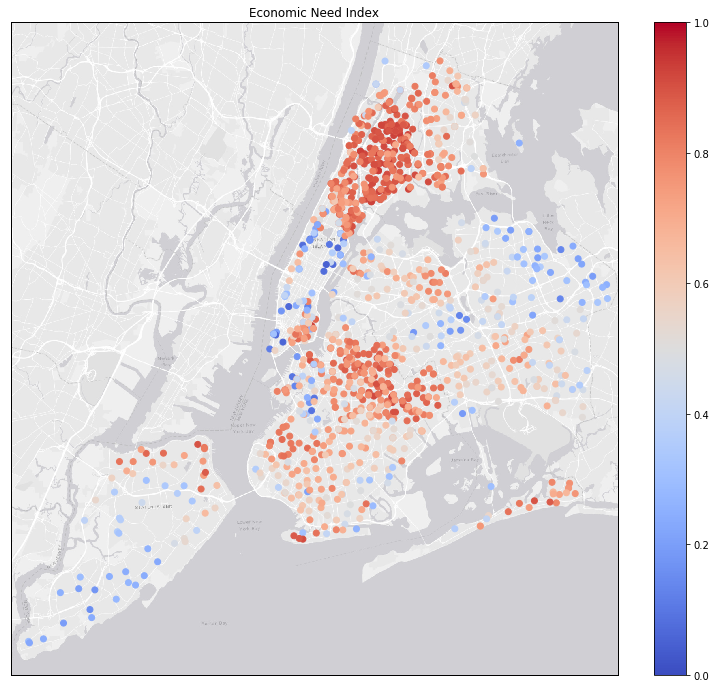

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
from pandas.plotting import parallel_coordinates

# general maps

def plot_basemap(ax=None):
    m = Basemap(projection='merc',
                llcrnrlat=40.486,
                llcrnrlon=-74.261,
                urcrnrlat=40.925,
                urcrnrlon=-73.691,
                resolution='c',
                epsg='3623')
    m.arcgisimage(
        server='http://server.arcgisonline.com/ArcGIS', 
        service='Canvas/World_Light_Gray_Base', 
        xpixels=1500,
        ypixels=None, 
        dpi=96,
        verbose=False,
        ax=ax)
    m.drawmapboundary(ax=ax)
    return m

def plot_cluster_map(cluster, data, **kwargs):
    plt.figure(figsize=(16,12))
    m = plot_basemap()
    for c, d in data.groupby(cluster):        
        lat = d['Latitude'].values
        lon = d['Longitude'].values
        x, y = m(lon, lat)
        plt.scatter(x, y, label=c, **kwargs)
    plt.title(cluster.name)
    plt.legend()
    
def plot_continuous_map(features, data, **kwargs):
    fig, ax = plt.subplots(figsize=(16,12))
    m = plot_basemap()    
    
    lat = data['Latitude'].values
    lon = data['Longitude'].values
    x, y = m(lon, lat)    
    plt.scatter(x, y, c=features, **kwargs)
    
    plt.title(features.name)
    plt.colorbar(fraction=0.046, pad=0.04)  # magic padding https://stackoverflow.com/a/26720422/
    
# minimap

def draw_minimap(data, ax):
    map = plot_basemap(ax)
    lat = data['Latitude'].values
    lon = data['Longitude'].values
    x, y = map(lon, lat)    
    ax.scatter(x, y, alpha=0.5, s=10)
    ax.set_title('Location of Schools')
    
# parallel coordinates

def plot_ethnic_distribution(data, ax):
    data = data[['Percent Hispanic', 'Percent Black', 'Percent White', 'Percent Asian']].copy()
    data['dummy'] = '-'
    parallel_coordinates(data, 'dummy', ax=ax)
    ax.set_title("Ethnic distribution")
    
def plot_framework_measures(data, ax):
    data = data[['Rigorous Instruction %', 'Collaborative Teachers %', 
                 'Supportive Environment %', 'Effective School Leadership %', 
                 'Strong Family-Community Ties %', 'Trust %']].copy()
    data.columns = [c[:-2] for c in data.columns]
    data['dummy'] = '-'
    parallel_coordinates(data, 'dummy', ax=ax)
    ax.set_title("Framework Measures")
    
def plot_percentage_of_4s(DBN, ax):
    data = percentage4s.loc[DBN]
    data['dummy'] = '-'
    parallel_coordinates(data, 'dummy', ax=ax)
    ax.set_title("Percentage of 4s")
    
# univariate KDE

def plot_eni(data, ax):
    data = data[data['Economic Need Index'].notnull()]
    sns.distplot(data['Economic Need Index'], hist=False, kde_kws={"shade": True})
    plt.xlim(0, 1)
    
def plot_ell(data, ax):
    sns.distplot(data['Percent ELL'], hist=False, kde_kws={"shade": True})
    plt.xlabel('Percent ELL (English Language Learner)')
    plt.xlim(0, 1)
    
def plot_estimated_income(data, ax):
    data = data[data['School Income Estimate'].notnull()].copy()
    data['School Income Estimate (thousands)'] = data['School Income Estimate'] / 1000
    sns.distplot(data['School Income Estimate (thousands)'], hist=False, kde_kws={"shade": True})
    
# bivariate KDE

def plot_proficiency(data, ax):
    # remove null entries
    notnull = data[['Average ELA Proficiency',
                    'Average Math Proficiency']].notnull().all(axis=1)
    data = data.loc[notnull]
    
    # plot
    x = data['Average ELA Proficiency']
    y = data['Average Math Proficiency']
#     plt.scatter(x, y, s=10, alpha=0.5)
    sns.kdeplot(x, y, shade=True, cmap='Blues', ax=ax)
    ax.set_xlim(1.0, 4.5)
    ax.set_ylim(1.0, 4.5)
    
def plot_attendance(data, ax):
    # remove null entries
    notnull = data[['Student Attendance Rate', 
                    'Percent of Students Chronically Absent']].notnull().all(axis=1)
    data = data.loc[notnull]
    
    # plot KDE
    x = data['Student Attendance Rate']
    y = data['Percent of Students Chronically Absent']
    sns.kdeplot(x, y, shade=True, cmap='Blues', ax=ax)
    ax.set_xlim(0.5, 1.00)
    ax.set_ylim(0.00, 0.5)
   
# bar plot
def plot_community_school(data, ax):
    cnt = data.groupby('Community School?').size()
    
    xs = ['Community School', 'Regular School']
    ys = [cnt[1], cnt[0]]
    ax.bar(xs, ys)
    
def plot_available_grades(data, ax):
    grades_cnt = data['Grades'].value_counts().to_dict()
    
    xs = grades
    ys = [grades_cnt.get(g, 0) for g in grades[:-1]]  # last element is 'Other'
    ys = ys + [data.shape[0] - np.sum(ys)]
    ax.bar(xs, ys)
    ax.set_title('Grades Available')
    
def plot_unavailable(data, ax):
    eni = data['Economic Need Index'].isnull().mean()
    sie = data['School Income Estimate'].isnull().mean()
    attendance = data[['Student Attendance Rate', 
                       'Percent of Students Chronically Absent']].isnull().any(axis=1).mean()
    proficiency = data[['Average ELA Proficiency',
                        'Average Math Proficiency']].isnull().any(axis=1).mean()
    framework = data[['Rigorous Instruction %', 'Collaborative Teachers %', 
                      'Supportive Environment %', 'Effective School Leadership %', 
                      'Strong Family-Community Ties %', 'Trust %']].isnull().any(axis=1).mean()

    xs = ['Attendance', 'Economic Need Index', 'NYS Test Proficiency', 
          'Framework Measures', 'School Income Estimate']
    ys = [attendance, eni, proficiency,
          framework, sie]

    ax.bar(xs, ys)
    ax.set_title('Percentage of null values')
    ax.tick_params(labelrotation=20)
    
# joint statistics

def plot_statistics(data):
    raise NotImplementedError
    
def plot_cluster_statistics(cluster, data):
    raise NotImplementedError
    
plot_continuous_map(df['Economic Need Index'], df, cmap='coolwarm', vmin=0, vmax=1)

---

In [ ]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1:])
ax3 = plt.subplot(gs[1, 0])
ax4 = plt.subplot(gs[1, 1])
ax5 = plt.subplot(gs[1, 2])
ax6 = plt.subplot(gs[1, 3])



data = df.copy().sample(50, random_state=1)

# plot racial coordinates
from pandas.plotting import parallel_coordinates

data = data[['Percent Hispanic', 'Percent Black', 'Percent White', 'Percent Asian']]
data['dummy'] = '-'
parallel_coordinates(data, 'dummy', ax=ax2)
ax2.set_title("Ethnic distribution");

plt.show()

In [ ]:
def plot_statistics(data):
    raise NotImplementedError
    
def plot_cluster_statistics(cluster, data):
    raise NotImplementedError

---

## Grouping the schools

In [1]:
import pandas as pd

df = pd.read_csv('../data/raw/2016 School Explorer.csv')

# set index
df = df.set_index('Location Code')
df.index.name = 'DBN'

# select columns
columns = [
    'Percent Asian',
    'Percent Black',
    'Percent Hispanic',
    'Percent White'
]
df = df[columns]

# parse percentage values
def parse_pct(x):
    return float(x[:-1]) / 100.0
df = df.applymap(parse_pct)

df.head()

,Percent Asian,Percent Black,Percent Hispanic,Percent White
DBN,,,,
01M015,0.05,0.32,0.60,0.01
01M019,0.10,0.20,0.63,0.06
01M020,0.35,0.08,0.49,0.04
01M034,0.05,0.29,0.63,0.04
01M063,0.04,0.20,0.65,0.10


In [134]:
import numpy as np
from scipy.stats import entropy
from sklearn.metrics.pairwise import pairwise_distances

def distance(x, y):
    return entropy(np.maximum(x, 0.005), np.maximum(y, 0.005))

def distance_kernel(data):
    return pairwise_distances(data, metric=distance, n_jobs=-1)

kernel = distance_kernel(df)

In [160]:
from sklearn.metrics import calinski_harabaz_score, silhouette_score

# these metrics are indicative of a good fit... the higher the better
for i in range(2, 21):
    model = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='average')    
    labels = model.fit_predict(kernel)
    score1 = calinski_harabaz_score(df, labels)
    score2 = silhouette_score(df, labels)
    print(i, score1, score2)

2 575.8507631552575 0.33823516438713586
3 1457.0820296309587 0.5199629206625567
4 1064.7087699295614 0.36858395640060143
5 816.3636281232389 0.32045006536078563
6 1118.0604952531307 0.38033340545314304
7 1126.2267094270308 0.42014300547931754
8 980.2418797312665 0.4143529214669579
9 885.8896316595456 0.35474449408346836
10 797.1916513332768 0.3359601043965502
11 745.0120883517334 0.3066517567831011
12 681.883748381853 0.2958975084447057
13 630.5761881307105 0.2711665771786537
14 588.0074889289444 0.26762258159479657
15 549.8865566701461 0.24929554836122028
16 534.7222741341794 0.2309951878065498
17 501.75086153224646 0.22657160702246246
18 491.9604398648129 0.2206618414370624
19 465.3437809473548 0.21751259461122657
20 447.6827772532738 0.21275173269469053


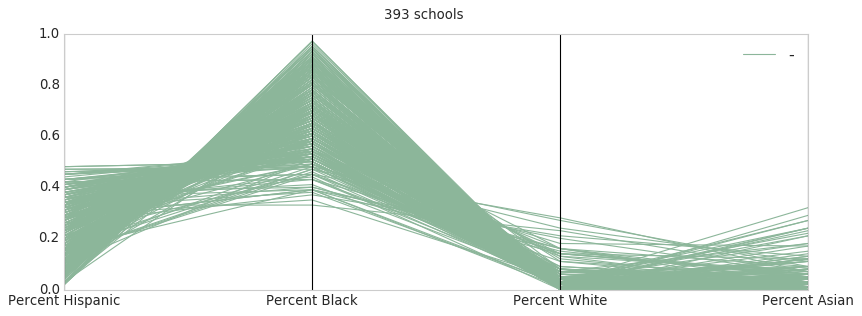

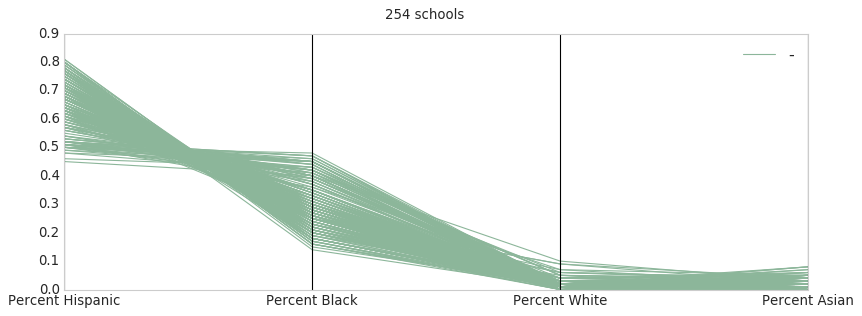

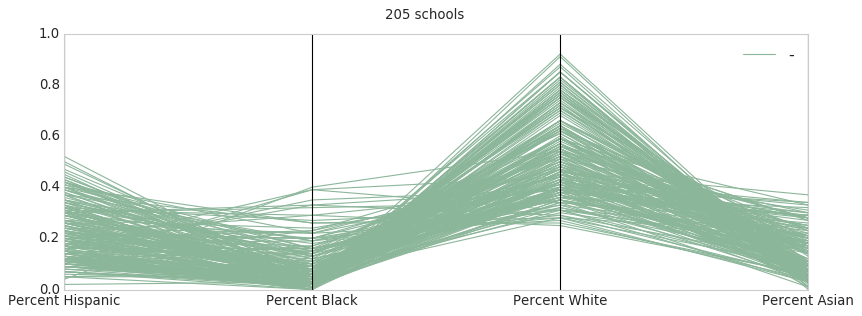

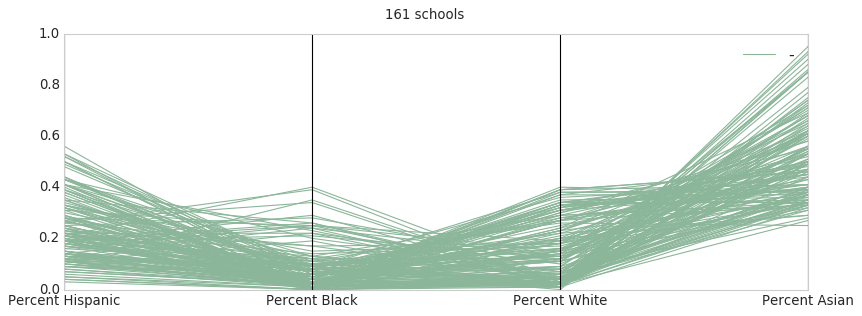

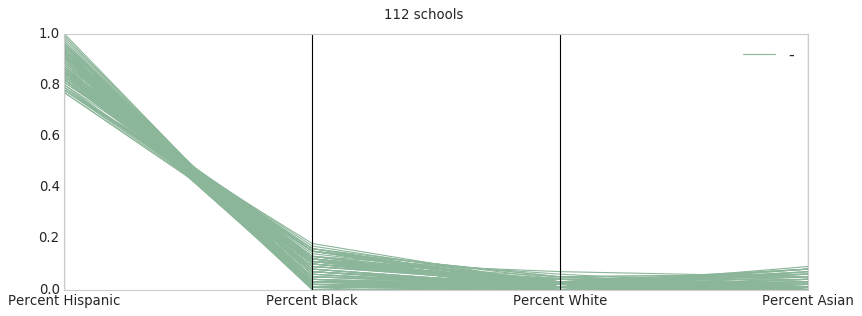

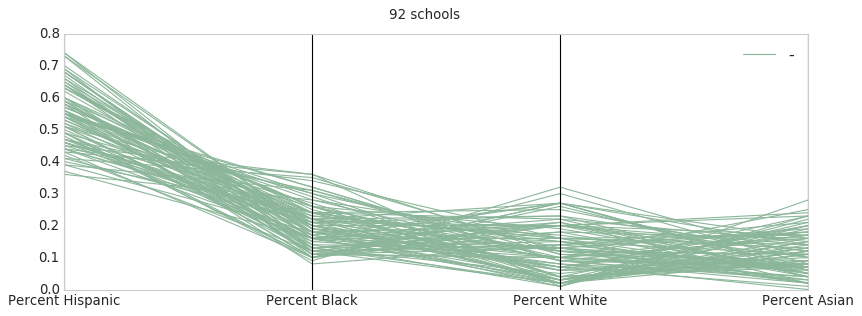

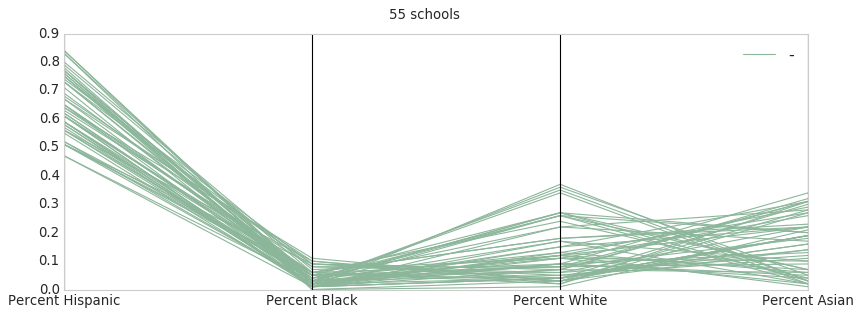

In [170]:
model = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='average')
labels = model.fit_predict(kernel)

for label in sorted(set(labels), key=lambda x: -df[labels==x].shape[0]):
    d = df[labels == label].copy()
    d = d[['Percent Hispanic', 'Percent Black', 'Percent White', 'Percent Asian']]
    d['dummy'] = '-'
    
    plt.figure(figsize=(12,4))
    plt.suptitle("{} schools".format(d.shape[0]))
    parallel_coordinates(d, 'dummy');